In [ ]:
%load_ext tensorboard
import os
os.environ["TF_CPP_MIN_VLOG_LEVEL"] = "2"
import tensorflow as tf
import random
import numpy as np
import pandas as pd
import tensorrt as trt
from typing import Sequence, Optional, Tuple

print("TF:", tf.__version__)
print("GPUs:", tf.config.list_physical_devices('GPU'))
print("TensorRt:", trt.__version__)

RANDOM_STATE = 42

random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)

# Tensorflow uniform random generator
g1 = tf.random.Generator.from_seed(RANDOM_STATE)

TARGET = "rucwar"
MIN_PER_CLASS = 50
OUTER_SPLITS = 2
INNER_SPLITS = 2
BATCH_SIZE = 32

SAMPLE_RATE = 16000
MAX_DURATION = 10 # seconds
NEG_POS_RATIO = 3
TRAIN_NEG_RATIO = 2
VAL_NEG_RATIO = 2
FILL_TYPE = "pad" # pad | tile
N_MELS = 128
N_FRAMES = 157
FRAME_OVERLAP = int(np.ceil(N_FRAMES * 0.5))

SECONDS = 5
BYTES_PER_SECOND = SECONDS * SAMPLE_RATE
INPUT_SHAPE = (N_MELS, N_FRAMES, 1)

2025-09-02 11:18:59.977887: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756804740.034870    1744 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756804740.051661    1744 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1756804740.184458    1744 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1756804740.184493    1744 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1756804740.184494    1744 computation_placer.cc:177] computation placer alr

TF: 2.19.0
GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
TensorRt: 10.13.2.6


In [2]:
from sklearn.model_selection import StratifiedGroupKFold
import os
import librosa

# birdclef sanity checks
def sanity_birdlcef(df: pd.DataFrame, target: str):
    # File integrity
    for r in df.itertuples():
        if os.path.isfile(r.path) is not True: # type:ignore
            print(f"[ERROR]: {r.path} is not valid!")
    
    # Dupicates
    dups = df['path'].duplicated().sum()  # or 'filename'
    print("Duplicate file rows:", dups)
    
    # Count summary
    print(f"Total Positives: {df[df['primary_label'] == target].shape[0]}")
    print(f"Total Negatives: {df[df['primary_label'] != target].shape[0]}")
    print(f"Avg samples per Class: {df['primary_label'].value_counts().mean():.0f}")



# Different functions for each dataset
def load_birdclef(audio_root, path, target, min_per_class = MIN_PER_CLASS):
    df = pd.read_csv(path)
    
    df["path"] = audio_root + "/" + df["primary_label"] + "/" + df["filename"]
    
    # Optional: drop rare classes (keeps CV stable)
    if min_per_class > 1:
        keep_labels = df["primary_label"].value_counts()
        keep_labels = keep_labels[keep_labels >= min_per_class].index
        df = df[df["primary_label"].isin(keep_labels)].reset_index(drop=True)
    
    # Perform sanity checks
    sanity_birdlcef(df, target)
    
    # Group based on auther + time te prevent straddeling
    df["group_key"] = df["author"] + df["time"]
    
    return df
    

os.chdir("/home/joris/Thesis/new_attempt")

birdclef_df = load_birdclef("datasets/birdclef_2021/train_short_audio", "datasets/birdclef_2021/train_metadata.csv", target=TARGET)


Duplicate file rows: 0
Total Positives: 154
Total Negatives: 61815
Avg samples per Class: 168


In [3]:
from sklearn.model_selection import StratifiedGroupKFold
import numpy as np
import pandas as pd

def make_nested_cv_splits(
    df: pd.DataFrame,
    target: str = TARGET,
    outer_splits: int = OUTER_SPLITS,
    inner_splits: int = INNER_SPLITS,
    random_state: int = RANDOM_STATE,
):
    """
    Build nested CV folds for binary BirdCLEF: target species = 1, others = 0.
    Uses StratifiedGroupKFold for both outer and inner splits to avoid leakage across groups.
    """
    
    # Binary labels for stratification
    y_all = (df["primary_label"] == target).astype(int).values
    groups_all = df["group_key"].astype(str).fillna("NA").values
    idx_all = np.arange(len(df))

    outer_kf = StratifiedGroupKFold(n_splits=outer_splits, shuffle=True, random_state=random_state)

    nested = []
    for k, (outer_tr_idx, outer_te_idx) in enumerate(outer_kf.split(idx_all, y=y_all, groups=groups_all), start=1):
        # Outer train/val pool and test set
        trval_idx = idx_all[outer_tr_idx]
        test_idx  = idx_all[outer_te_idx]

        y_trval   = y_all[outer_tr_idx]
        groups_trval = groups_all[outer_tr_idx]

        # Inner CV on the outer train/val pool
        inner_kf = StratifiedGroupKFold(n_splits=inner_splits, shuffle=True, random_state=random_state)
        inner_folds = []
        for j, (inner_tr_rel, inner_va_rel) in enumerate(inner_kf.split(trval_idx, y=y_trval, groups=groups_trval), start=1):
            # Map relative indices back to global indices
            inner_tr_idx = trval_idx[inner_tr_rel]
            inner_va_idx = trval_idx[inner_va_rel]

            inner_folds.append({
                "inner_fold": j,
                "inner_train_idx": inner_tr_idx,
                "inner_val_idx":   inner_va_idx,
            })

        nested.append({
            "outer_fold": k,
            "outer_train_idx": trval_idx,
            "outer_test_idx":  test_idx,
            "inner_folds": inner_folds,
            "train_pos_ratio": float(y_all[outer_tr_idx].mean()), # type: ignore
            "test_pos_ratio":  float(y_all[outer_te_idx].mean()), # type: ignore
        })

    return nested

    
    
cross_validation_sets = make_nested_cv_splits(birdclef_df)

In [ ]:
# Augments
def aug_gaussian_noise_tf(audio, snr_db):
    """
    Add Gaussian noise to a waveform at a given SNR (dB).
    
    Args:
        audio (tf.Tensor): 1D or 2D waveform tensor (e.g. [time] or [batch, time]).
        snr_db (float): Target signal-to-noise ratio in dB.
    
    Returns:
        tf.Tensor: Noisy waveform with the specified SNR.
    """
    # Calculate RMS of the signal
    rms_signal = tf.sqrt(tf.reduce_mean(tf.square(audio), axis=-1, keepdims=True))

    # Convert SNR from dB to linear scale
    snr_linear = 10 ** (snr_db / 20.0)

    # Desired noise RMS
    rms_noise = rms_signal / snr_linear

    # Generate Gaussian noise
    noise = g1.normal(shape=tf.shape(audio), dtype=tf.float32)

    # Normalize noise to unit RMS
    rms_noise_current = tf.sqrt(tf.reduce_mean(tf.square(noise), axis=-1, keepdims=True))
    noise = noise * (rms_noise / (rms_noise_current + 1e-8))

    return audio + noise

def aug_loudness_norm_tf(audio, target_db=-20.0, eps=1e-8):
    rms = tf.sqrt(tf.reduce_mean(tf.square(audio), axis=-1, keepdims=True) + eps)
    rms_db = 20.0 * tf.math.log(rms + eps) / tf.math.log(10.0)
    gain = 10.0 ** ((target_db - rms_db) / 20.0)
    return audio * gain

def aug_specaugment_tf(spec, max_freq_masks=2, max_time_masks=2,
                       max_freq_width=16, max_time_width=32):
    spec = tf.identity(spec)
    def _mask_freq(s):
        f = tf.shape(s)[-2]; t = tf.shape(s)[-1]
        w = g1.uniform((), 0, max_freq_width+1, dtype=tf.int32)
        start = g1.uniform((), 0, tf.maximum(f - w, 1), dtype=tf.int32)
        mask = tf.concat([tf.ones([start, t]), tf.zeros([w, t]), tf.ones([f - start - w, t])], axis=0)
        return s * mask
    def _mask_time(s):
        f = tf.shape(s)[-2]; t = tf.shape(s)[-1]
        w = g1.uniform((), 0, max_time_width+1, dtype=tf.int32)
        start = g1.uniform((), 0, tf.maximum(t - w, 1), dtype=tf.int32)
        mask = tf.concat([tf.ones([f, start]), tf.zeros([f, w]), tf.ones([f, t - start - w])], axis=1)
        return s * mask
    for _ in range(2):  # loop vars must be static; use fixed counts
        spec = _mask_freq(spec)
        spec = _mask_time(spec)
    return spec

def mixup_batch(features, labels, alpha=0.4):
    # features: [B, ...], labels: [B, C]
    B = tf.shape(features)[0]
    idx = tf.random.shuffle(tf.range(B))
    f2, y2 = tf.gather(features, idx, axis=0), tf.gather(labels, idx, axis=0)
    lam1 = tf.random.gamma([B, 1], alpha); lam2 = tf.random.gamma([B, 1], alpha)
    lam = lam1 / (lam1 + lam2)  # Beta(alpha, alpha)
    # reshape lam to broadcast over feature dims
    while tf.rank(lam) < tf.rank(features):
        lam = tf.expand_dims(lam, -1)
    x = lam * features + (1.0 - lam) * f2
    y = tf.squeeze(lam, axis=list(range(1, tf.rank(lam)))) * labels + (1.0 - tf.squeeze(lam, axis=list(range(1, tf.rank(lam))))) * y2
    return x, y

I0000 00:00:1756804749.830805    1744 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9509 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4080 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


In [5]:
import subprocess

def load_ogg_ffmpeg(path, sr=SAMPLE_RATE):
    path = path.decode("utf-8")
    cmd = [
        "ffmpeg", "-i", path, "-f", "f32le",
        "-ac", "1", "-ar", str(sr), "pipe:1", "-loglevel", "quiet"
    ]
    out = subprocess.check_output(cmd)
    audio = np.frombuffer(out, np.float32)
    return audio

def load_ogg_librosa(path, sr=SAMPLE_RATE):
    path = path.decode("utf-8")
    y, sr = librosa.load(path, sr=SAMPLE_RATE)
    return y

from librosa._typing import _STFTPad

def generate_mel_spectrogram(audio, sr = SAMPLE_RATE, n_fft=1024, n_mels=128, hop_length=512, win_length=None, 
                       window:str='hann', center=True, pad_mode:_STFTPad='constant', power=2.0, fmin=200, 
                       fmax=8000, norm='slaney'):
    # Generate mel spectrogram
    spec = librosa.feature.melspectrogram(y=audio, sr=sr, n_fft=n_fft, n_mels=n_mels, hop_length=hop_length, win_length=win_length, window=window, center=center, pad_mode=pad_mode, power=power, fmin=fmin, fmax=fmax, norm=norm)
    # Convert to dB
    spec = librosa.power_to_db(spec, ref=np.max)
    return spec


def audio_pipeline(filename: Sequence[str], augment=False, gaussian=0):
    # Load audio file as tensor 
    audio_file = tf.numpy_function(load_ogg_librosa, [filename, SAMPLE_RATE], tf.float32)
    
    # Remove last dimension
    waveform = audio_file[:SAMPLE_RATE * MAX_DURATION] # type: ignore
    
    processed = waveform[:SAMPLE_RATE * SECONDS]
        
    if gaussian > 0:
        processed = aug_gaussian_noise_tf(processed, gaussian)
    
    n = tf.shape(processed)[0]
    # If shorter than desired, pad or tile
    if FILL_TYPE == "pad":
        pad = tf.maximum(0, SAMPLE_RATE * SECONDS - n)
        processed = tf.pad(processed, paddings=[[0, pad]])
    else:  # tile
        repeats = tf.maximum(
            1,
            tf.cast(
                tf.math.ceil((SAMPLE_RATE * SECONDS) / tf.cast(n, tf.float32)), tf.int32
            ),
        )
        processed = tf.tile(processed, [repeats])
        processed = processed[: SAMPLE_RATE * SECONDS]
    
    # Band filter
    from scipy import signal
    b, a = signal.butter(4, [200, 7999], fs=SAMPLE_RATE, btype='band')
    band_filter = tf.py_function(signal.lfilter, [b, a, processed], Tout=tf.float32, name="Filter")

    db_mel_spectrogram = tf.numpy_function(
        generate_mel_spectrogram, [band_filter, SAMPLE_RATE], Tout=tf.float32
    )

    db_mel_spectrogram = tf.ensure_shape(db_mel_spectrogram, shape=(N_MELS, N_FRAMES))

    
    return db_mel_spectrogram

In [ ]:
import tensorflow.keras as keras

# --------- Simple binary CNN ----------
def build_binary_cnn(
    input_shape=(128, 64, 1),
    lr=1e-3,
    l2=1e-4,
    dropout=0.25,
    gamma=2.0,
    alpha=0.25,
):
    """
    Binary classifier for log-mel spectrograms (target vs non-target).
    Output: single sigmoid unit.
    Loss: Binary Focal Cross-Entropy (with safe fallbacks).
    """
    L2 = keras.regularizers.l2(l2)
    Conv = keras.layers.Conv2D

    inputs = keras.Input(shape=input_shape)

    # Block 1
    x = Conv(32, (3, 3), padding="same", kernel_regularizer=L2)(inputs)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.ReLU()(x)
    x = Conv(32, (3, 3), padding="same", kernel_regularizer=L2)(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.ReLU()(x)
    x = keras.layers.MaxPooling2D((2, 2))(x)   # 128x64 -> 64x32
    x = keras.layers.Dropout(dropout)(x)

    # Block 2
    x = Conv(64, (3, 3), padding="same", kernel_regularizer=L2)(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.ReLU()(x)
    x = Conv(64, (3, 3), padding="same", kernel_regularizer=L2)(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.ReLU()(x)
    x = keras.layers.MaxPooling2D((2, 2))(x)   # 64x32 -> 32x16
    x = keras.layers.Dropout(dropout)(x)

    # Block 3
    x = Conv(96, (3, 3), padding="same", kernel_regularizer=L2)(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.ReLU()(x)
    x = Conv(96, (3, 3), padding="same", kernel_regularizer=L2)(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.ReLU()(x)
    x = keras.layers.MaxPooling2D((2, 2))(x)   # 32x16 -> 16x8
    x = keras.layers.Dropout(dropout)(x)

    # Head
    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Dense(128, activation="relu", kernel_regularizer=L2)(x)
    x = keras.layers.Dropout(dropout)(x)
    outputs = keras.layers.Dense(1, activation="sigmoid")(x)  # binary

    model = keras.Model(inputs, outputs)
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        loss=keras.losses.BinaryFocalCrossentropy(
            alpha=alpha,
            gamma=gamma,
            name='binary_focal_crossentropy'
        ),
        metrics=[
            keras.metrics.MeanSquaredError(name='Brier score'),
            keras.metrics.BinaryAccuracy(name="acc", threshold=0.5),
            keras.metrics.AUC(curve="ROC", name="auc"),
            keras.metrics.AUC(curve="PR",  name="auprc"),
            keras.metrics.Precision(name="precision", thresholds=0.5),
            keras.metrics.Recall(name="recall", thresholds=0.5),
        ],
    )
    return model


In [ ]:
import math

def _map_pos(x, y):
    return audio_pipeline(x, augment=True), y

def _map_neg(x, y):
    return audio_pipeline(x, augment=True), y

def _map_pos_aug(x, y):
    return audio_pipeline(x, augment=True, gaussian=10), y

def _map_neg_aug(x, y):
    return audio_pipeline(x, augment=True, gaussian=10), y

def plan_epoch_counts(n_pos_train: int, neg_pos_ratio: float = 2.0) -> Tuple[int, int]:
    P_pos = int(n_pos_train)
    P_neg = int(round(neg_pos_ratio * P_pos))
    return P_pos, P_neg 

def sample_train_negatives(neg_all: Sequence[str], n_neg: int, seed: Optional[int] = None) -> Sequence[str]:
    n = min(n_neg, len(neg_all))
    rng = random.Random(seed)
    return rng.sample(list(neg_all), n) if n > 0 else []

def make_fixed_val_negatives(neg_all: Sequence[str], n_pos_val: int, neg_pos_ratio: int = NEG_POS_RATIO, seed: int = RANDOM_STATE) -> Sequence[str]:
    n_neg = min(neg_pos_ratio * n_pos_val, len(neg_all))
    rng = random.Random(seed)
    return rng.sample(list(neg_all), n_neg) if n_neg > 0 else []

STEPS_PER_TRAINING_EPOCH = 0
STEPS_PER_VALIDATION_EPOCH = 0

def build_train_dataset(pos_files: Sequence[str], neg_files: Sequence[str], batch_size: int = BATCH_SIZE, shuffle: bool = True) -> tf.data.Dataset:
    global STEPS_PER_TRAINING_EPOCH
    
    labels_pos = tf.ones([len(pos_files)], dtype=tf.float32)
    labels_neg = tf.zeros([len(neg_files)], dtype=tf.float32)
    
    ds_pos = tf.data.Dataset.from_tensor_slices((list(pos_files), labels_pos)).map(_map_pos, num_parallel_calls=tf.data.AUTOTUNE)
    ds_pos_aug = tf.data.Dataset.from_tensor_slices((list(pos_files), labels_pos)).map(_map_pos_aug, num_parallel_calls=tf.data.AUTOTUNE)
    ds_neg = tf.data.Dataset.from_tensor_slices((list(neg_files), labels_neg)).map(_map_neg, num_parallel_calls=tf.data.AUTOTUNE)
    ds_neg_aug = tf.data.Dataset.from_tensor_slices((list(neg_files), labels_neg)).map(_map_neg_aug, num_parallel_calls=tf.data.AUTOTUNE)

    # Set the amount of steps
    STEPS_PER_TRAINING_EPOCH = math.ceil((len(ds_pos) + len(ds_pos_aug))/BATCH_SIZE)
    ds = ds_pos.concatenate(ds_neg).concatenate(ds_pos_aug).concatenate(ds_neg_aug)
    if shuffle:
        ds = ds.shuffle(buffer_size=len(pos_files) + len(neg_files), seed=RANDOM_STATE, reshuffle_each_iteration=True)
    ds = ds.batch(batch_size).cache().repeat()
    return ds


def build_val_dataset(pos_files: Sequence[str], neg_files_fixed: Sequence[str], batch_size: int = BATCH_SIZE) -> tf.data.Dataset:
    global STEPS_PER_VALIDATION_EPOCH

    y_pos = tf.ones([len(pos_files)],        dtype=tf.float32)
    y_neg = tf.zeros([len(neg_files_fixed)], dtype=tf.float32)

    ds_pos = tf.data.Dataset.from_tensor_slices((list(pos_files), y_pos)).map(lambda x,y: (audio_pipeline(x, augment=False), y), num_parallel_calls=tf.data.AUTOTUNE)
    ds_neg = tf.data.Dataset.from_tensor_slices((list(neg_files_fixed), y_neg)).map(lambda x,y: (audio_pipeline(x, augment=False), y), num_parallel_calls=tf.data.AUTOTUNE)

    STEPS_PER_VALIDATION_EPOCH = math.ceil((len(y_pos)) / BATCH_SIZE)

    return ds_pos.concatenate(ds_neg).batch(batch_size).cache()

def build_file_lists(df: pd.DataFrame, idx, target=TARGET):
    sub = df.iloc[idx]
    pos = sub[sub.primary_label == target]["path"].tolist()
    neg = sub[sub.primary_label != target]["path"].tolist()
    return pos, neg

def make_epoch_train_dataset(pos_tr_all: Sequence[str], neg_tr_all: Sequence[str],
                             neg_pos_ratio: float = 2.0, batch_size: int = BATCH_SIZE, seed: Optional[int] = RANDOM_STATE) -> tf.data.Dataset:
    P_pos, P_neg = plan_epoch_counts(len(pos_tr_all), neg_pos_ratio)
    neg_epoch = sample_train_negatives(neg_tr_all, P_neg, seed=seed)
    return build_train_dataset(pos_tr_all, neg_epoch, batch_size=batch_size, shuffle=True)

def make_fixed_val_dataset(pos_va_all: Sequence[str], neg_va_all: Sequence[str],
                           neg_pos_ratio: int = 3, batch_size: int = BATCH_SIZE, seed: int = RANDOM_STATE) -> tf.data.Dataset:
    neg_fixed = make_fixed_val_negatives(neg_va_all, len(pos_va_all), neg_pos_ratio=neg_pos_ratio, seed=seed)
    return build_val_dataset(pos_va_all, neg_fixed, batch_size=batch_size)


def build_all_file_lists(df: pd.DataFrame, folds: dict, epoch: int = 0):
    out = []
    for fold in folds:
        outer_fold = int(fold["outer_fold"])
        outer_train_idx = fold["outer_train_idx"]
        outer_test_idx = fold["outer_test_idx"]
    
        # Build the file lists for the outer fold
        pos_tr_all, neg_tr_all = build_file_lists(df, outer_train_idx)    
        pos_test_all, neg_test_all = build_file_lists(df, outer_test_idx)
    

        # Rotate negatives each epoch via seed that depends on (outer, inner, epoch)
        outer_train_ds = make_epoch_train_dataset(
            pos_tr_all,
            neg_tr_all,
            neg_pos_ratio=TRAIN_NEG_RATIO,
            batch_size=BATCH_SIZE,
            seed=outer_fold,
        )

        outer_test_ds = make_fixed_val_dataset(
            pos_test_all,
            neg_test_all,
            neg_pos_ratio=VAL_NEG_RATIO,
            batch_size=BATCH_SIZE,
            seed=outer_fold,  # fixed per outer fold
        )
    
        
        inner_list = []
        for inner in fold["inner_folds"]:
            inner_fold = int(inner["inner_fold"])
            inner_train_idx = inner["inner_train_idx"]
            inner_val_idx   = inner["inner_val_idx"]

            pos_tr_all, neg_tr_all = build_file_lists(df, inner_train_idx)
            pos_va_all, neg_va_all = build_file_lists(df, inner_val_idx)

            # Rotate negatives each epoch via seed that depends on (outer, inner, epoch)
            train_ds = make_epoch_train_dataset(
                pos_tr_all,
                neg_tr_all,
                neg_pos_ratio=TRAIN_NEG_RATIO,
                batch_size=BATCH_SIZE,
                seed=outer_fold * 100_000 + inner_fold * 1_000 + epoch,
            )

            # Fixed validation and test datasets (reproducible seeds per outer/inner)
            val_ds = make_fixed_val_dataset(
                pos_va_all,
                neg_va_all,
                neg_pos_ratio=VAL_NEG_RATIO,
                batch_size=BATCH_SIZE,
                seed=outer_fold * 100_000 + inner_fold,
            )

            test_ds = make_fixed_val_dataset(
                pos_test_all,
                neg_test_all,
                neg_pos_ratio=VAL_NEG_RATIO,
                batch_size=BATCH_SIZE,
                seed=outer_fold,  # fixed per outer fold
            )

            inner_list.append({
                "inner_fold": inner_fold,
                "train_ds": train_ds,
                "val_ds":   val_ds,
                "test_ds":  test_ds,
            })
        out.append({"outer_fold": outer_fold, "train_ds":outer_train_ds, "test_ds":outer_test_ds, "inner": inner_list})
    return out
        

datasets = build_all_file_lists(birdclef_df, cross_validation_sets)

In [8]:
per_fold_results = []

EPOCHS_PER_FOLD = 50

hparams_per_fold = {
    0: {"lr":1e-3, "gamma":1.0, "alpha":0.25},
    1: {"lr":1e-3, "gamma":2.0, "alpha":0.5},
    2: {"lr":1e-3, "gamma":3.0, "alpha":0.75},
    3: {"lr":1e-3, "gamma":4.0, "alpha":0.25},
    4: {"lr":1e-3, "gamma":5.0, "alpha":0.25},
}

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early = EarlyStopping(monitor="auprc", mode="max", patience=8, min_delta=1e-3, restore_best_weights=True, verbose=1)
ckpt  = ModelCheckpoint("output/best.keras", monitor="auprc", mode="max", save_best_only=True, verbose=1)


for outer_fold in datasets:
    print(f"[INFO]: Running outer fold: {outer_fold["outer_fold"]}")
    inner_scores = []
    for inner_fold in outer_fold["inner"]:
        print(f"[INFO]: Running inner fold: {inner_fold["inner_fold"]}")
        model = build_binary_cnn(input_shape=INPUT_SHAPE, 
                                 lr=hparams_per_fold[inner_fold["inner_fold"]]["lr"], 
                                 gamma=hparams_per_fold[inner_fold["inner_fold"]]["gamma"], 
                                 alpha=hparams_per_fold[inner_fold["inner_fold"]]["alpha"])

        model.fit(
            inner_fold["train_ds"],
            epochs = EPOCHS_PER_FOLD,
            validation_data=inner_fold["val_ds"],
            steps_per_epoch=STEPS_PER_TRAINING_EPOCH,
            validation_steps = STEPS_PER_VALIDATION_EPOCH,
            verbose=1,
            callbacks=[early, ckpt]
        )
        
        vals = model.evaluate(inner_fold["test_ds"], verbose=0)
        print(model.metrics_names)
        print(vals)
        inner_scores.append(vals[2])
    
    mean_test_acc = np.mean(inner_scores)
    print(f"Inner CV mean test acc: {mean_test_acc:.3f}")
    
    # Retrain with the best parameters
    best_inner = np.argmax(inner_scores)
    
    model = build_binary_cnn(input_shape=INPUT_SHAPE, 
                                lr=hparams_per_fold[best_inner]["lr"], 
                                gamma=hparams_per_fold[best_inner]["gamma"], 
                                alpha=hparams_per_fold[best_inner]["alpha"])
    model.fit(
        outer_fold["train_ds"],
        epochs = EPOCHS_PER_FOLD,
        steps_per_epoch=STEPS_PER_TRAINING_EPOCH,
        validation_steps = STEPS_PER_VALIDATION_EPOCH,
        verbose=1,
        callbacks=[early, ckpt]
    )
    
    vals = model.evaluate(outer_fold["test_ds"], verbose=0)
    per_fold_results.append(vals[2])

print(per_fold_results)

[INFO]: Running outer fold: 1
[INFO]: Running inner fold: 1
Epoch 1/50


I0000 00:00:1756804763.737279    2336 service.cc:152] XLA service 0x7e8bfc008c50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1756804763.737617    2336 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4080 Laptop GPU, Compute Capability 8.9
2025-09-02 11:19:24.161370: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1756804765.679282    2336 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-09-02 11:19:26.885134: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2890', 36 bytes spill stores, 36 bytes spill loads

2025-09-02 11:19:27.031453: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusio

1/2 ━━━━━━━━━━━━━━━━━━━━ 18s 19s/step - Brier score: 0.2627 - acc: 0.5625 - auc: 0.5893 - auprc: 0.4486 - loss: 0.3175 - precision: 0.0000e+00 - recall: 0.0000e+00

I0000 00:00:1756804774.276362    2336 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - Brier score: 0.2453 - acc: 0.5859 - auc: 0.6366 - auprc: 0.5697 - loss: 0.2885 - precision: 0.3158 - recall: 0.2000       
Epoch 1: auprc improved from None to 0.69076, saving model to output/best.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 24s 5s/step - Brier score: 0.2278 - acc: 0.6094 - auc: 0.6838 - auprc: 0.6908 - loss: 0.2594 - precision: 0.6316 - recall: 0.4000 - val_Brier score: 0.4158 - val_acc: 0.5833 - val_auc: 0.5156 - val_auprc: 0.4381 - val_loss: 3.4641 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - Brier score: 0.2678 - acc: 0.4453 - auc: 0.6387 - auprc: 0.4425 - loss: 0.2696 - precision: 0.3185 - recall: 0.7611
Epoch 2: auprc did not improve from 0.69076
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 284ms/step - Brier score: 0.2602 - acc: 0.4844 - auc: 0.6159 - auprc: 0.4039 - loss: 0.2545 - precision: 0.3171 - recall: 0.7222 - val_Brier score: 0.4086 - val_acc: 0.5833 - val_auc: 0.4900 - val_auprc: 0.4

2025-09-02 11:19:41.821378: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3889', 8 bytes spill stores, 8 bytes spill loads



2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - Brier score: 0.2356 - acc: 0.5000 - auc: 0.5403 - auprc: 0.4016 - loss: 0.2230 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 5: auprc did not improve from 0.69076
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 189ms/step - Brier score: 0.2383 - acc: 0.5000 - auc: 0.5806 - auprc: 0.4521 - loss: 0.2252 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_Brier score: 0.4162 - val_acc: 0.5833 - val_auc: 0.4911 - val_auprc: 0.4008 - val_loss: 3.9703 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - Brier score: 0.2628 - acc: 0.4375 - auc: 0.4316 - auprc: 0.4305 - loss: 0.2508 - precision: 0.2812 - recall: 0.1587
Epoch 6: auprc did not improve from 0.69076
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - Brier score: 0.2505 - acc: 0.5000 - auc: 0.4980 - auprc: 0.4071 - loss: 0.2363 - precision: 0.3125 - recall: 0.1923 - val_Brier score: 0.4164 - val_acc: 0.5833 - val_auc: 0.4911 - val_auprc: 0.4008 - val_loss: 4.3021 - va

2025-09-02 11:19:53.647844: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_346', 20 bytes spill stores, 20 bytes spill loads



['loss', 'compile_metrics']
[2.829702377319336, 0.3327687084674835, 0.6666666865348816, 0.49612244963645935, 0.32514822483062744, 0.0, 0.0]
[INFO]: Running inner fold: 2
Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - Brier score: 0.3591 - acc: 0.5469 - auc: 0.4744 - auprc: 0.4269 - loss: 0.7362 - precision: 0.2857 - recall: 0.0741        
Epoch 1: auprc did not improve from 0.69076
2/2 ━━━━━━━━━━━━━━━━━━━━ 17s 5s/step - Brier score: 0.3167 - acc: 0.5938 - auc: 0.5210 - auprc: 0.4253 - loss: 0.6315 - precision: 0.5714 - recall: 0.1481 - val_Brier score: 0.4571 - val_acc: 0.5417 - val_auc: 0.5133 - val_auprc: 0.4944 - val_loss: 3.6037 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - Brier score: 0.2423 - acc: 0.5703 - auc: 0.5719 - auprc: 0.4394 - loss: 0.1489 - precision: 0.3911 - recall: 0.5682
Epoch 2: auprc did not improve from 0.69076
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 271ms/step - Brier score: 0.2479 - acc: 0.5781 - auc: 0.5528 -

2025-09-02 11:20:48.140694: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_4448', 4 bytes spill stores, 4 bytes spill loads

2025-09-02 11:20:48.251120: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2922', 20 bytes spill stores, 20 bytes spill loads



2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - Brier score: 0.2017 - acc: 0.7411 - auc: 0.5224 - auprc: 0.3209 - loss: 0.3480 - precision: 0.1667 - recall: 0.0357          
Epoch 8: auprc did not improve from 0.69076
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - Brier score: 0.2046 - acc: 0.7321 - auc: 0.5306 - auprc: 0.3572 - loss: 0.3501 - precision: 0.3333 - recall: 0.0714
Epoch 8: early stopping
Restoring model weights from the end of the best epoch: 1.
[INFO]: Running outer fold: 2
[INFO]: Running inner fold: 1
Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - Brier score: 0.3224 - acc: 0.3984 - auc: 0.4002 - auprc: 0.4049 - loss: 0.4367 - precision: 0.4142 - recall: 0.6833

2025-09-02 11:21:19.439346: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_346', 20 bytes spill stores, 20 bytes spill loads




Epoch 1: auprc did not improve from 0.69076
2/2 ━━━━━━━━━━━━━━━━━━━━ 19s 5s/step - Brier score: 0.3060 - acc: 0.4219 - auc: 0.4456 - auprc: 0.4272 - loss: 0.3939 - precision: 0.4146 - recall: 0.5667 - val_Brier score: 0.2198 - val_acc: 0.6667 - val_auc: 0.5502 - val_auprc: 0.4079 - val_loss: 0.2337 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - Brier score: 0.2291 - acc: 0.6875 - auc: 0.6353 - auprc: 0.5197 - loss: 0.2431 - precision: 0.6316 - recall: 0.8000

/home/joris/.pyenv/versions/3.12.11/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - Brier score: 0.2244 - acc: 0.7031 - auc: 0.6630 - auprc: 0.5244 - loss: 0.2304 - precision: 0.6306 - recall: 0.7400
Epoch 2: auprc did not improve from 0.69076
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 467ms/step - Brier score: 0.2198 - acc: 0.7188 - auc: 0.6908 - auprc: 0.5291 - loss: 0.2176 - precision: 0.6296 - recall: 0.6800 - val_Brier score: 0.4137 - val_acc: 0.3333 - val_auc: 0.4599 - val_auprc: 0.2941 - val_loss: 0.6389 - val_precision: 0.3333 - val_recall: 1.0000
Epoch 3/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - Brier score: 0.1974 - acc: 0.6875 - auc: 0.6346 - auprc: 0.2382 - loss: 0.1961 - precision: 0.1667 - recall: 0.1667
Epoch 3: auprc did not improve from 0.69076
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - Brier score: 0.2167 - acc: 0.6875 - auc: 0.5234 - auprc: 0.2004 - loss: 0.2227 - precision: 0.1818 - recall: 0.1538 - val_Brier score: 0.3973 - val_acc: 0.3333 - val_auc: 0.4622 - val_auprc: 0.2948 - val_loss: 0.5801 - val_precision: 0.3333 - v

2025-09-02 11:21:32.807341: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_346', 20 bytes spill stores, 20 bytes spill loads



['loss', 'compile_metrics']
[0.24334898591041565, 0.2232305407524109, 0.6666666865348816, 0.5051729083061218, 0.3245750665664673, 0.0, 0.0]
[INFO]: Running inner fold: 2
Epoch 1/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 10s 11s/step - Brier score: 0.2484 - acc: 0.4688 - auc: 0.5317 - auprc: 0.5341 - loss: 0.1590 - precision: 0.3333 - recall: 0.2143
Epoch 1: auprc did not improve from 0.69076
2/2 ━━━━━━━━━━━━━━━━━━━━ 15s 4s/step - Brier score: 0.2656 - acc: 0.4688 - auc: 0.5559 - auprc: 0.4791 - loss: 0.2225 - precision: 0.3548 - recall: 0.4400 - val_Brier score: 0.2869 - val_acc: 0.4583 - val_auc: 0.4436 - val_auprc: 0.5022 - val_loss: 0.2080 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - Brier score: 0.2530 - acc: 0.4375 - auc: 0.4638 - auprc: 0.2570 - loss: 0.1600 - precision: 0.2353 - recall: 0.4444

2025-09-02 11:21:51.791234: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3889', 8 bytes spill stores, 8 bytes spill loads



2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - Brier score: 0.2482 - acc: 0.4915 - auc: 0.5136 - auprc: 0.2548 - loss: 0.1692 - precision: 0.2605 - recall: 0.4949   

2025-09-02 11:21:56.346050: W tensorflow/core/kernels/data/cache_dataset_ops.cc:916] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.



Epoch 2: auprc did not improve from 0.69076
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - Brier score: 0.2434 - acc: 0.5455 - auc: 0.5634 - auprc: 0.2526 - loss: 0.1784 - precision: 0.2857 - recall: 0.5455 - val_Brier score: 0.4346 - val_acc: 0.4583 - val_auc: 0.4200 - val_auprc: 0.4992 - val_loss: 0.9143 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step - Brier score: 0.2568 - acc: 0.6328 - auc: 0.5116 - auprc: 0.4787 - loss: 0.2398 - precision: 1.0000 - recall: 0.1114

2025-09-02 11:21:59.576030: W tensorflow/core/kernels/data/cache_dataset_ops.cc:916] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.



Epoch 3: auprc did not improve from 0.69076
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - Brier score: 0.2508 - acc: 0.6406 - auc: 0.4636 - auprc: 0.4073 - loss: 0.2187 - precision: 1.0000 - recall: 0.0800 - val_Brier score: 0.5415 - val_acc: 0.4583 - val_auc: 0.4886 - val_auprc: 0.5211 - val_loss: 6.0675 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - Brier score: 0.2053 - acc: 0.6847 - auc: 0.6065 - auprc: 0.3640 - loss: 0.1227 - precision: 0.3095 - recall: 0.1465 

2025-09-02 11:22:04.255916: W tensorflow/core/kernels/data/cache_dataset_ops.cc:916] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.



Epoch 4: auprc did not improve from 0.69076
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - Brier score: 0.2060 - acc: 0.6818 - auc: 0.6019 - auprc: 0.2987 - loss: 0.1222 - precision: 0.2857 - recall: 0.1818 - val_Brier score: 0.5417 - val_acc: 0.4583 - val_auc: 0.5000 - val_auprc: 0.5417 - val_loss: 10.3369 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - Brier score: 0.2444 - acc: 0.5469 - auc: 0.5665 - auprc: 0.4786 - loss: 0.1642 - precision: 0.4143 - recall: 0.2271

2025-09-02 11:22:09.809197: W tensorflow/core/kernels/data/cache_dataset_ops.cc:916] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.



Epoch 5: auprc did not improve from 0.69076
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - Brier score: 0.2419 - acc: 0.5625 - auc: 0.5477 - auprc: 0.4369 - loss: 0.1552 - precision: 0.4000 - recall: 0.2400 - val_Brier score: 0.5417 - val_acc: 0.4583 - val_auc: 0.5000 - val_auprc: 0.5417 - val_loss: 11.8674 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - Brier score: 0.2304 - acc: 0.5767 - auc: 0.5260 - auprc: 0.2520 - loss: 0.1266 - precision: 0.2517 - recall: 0.3030

2025-09-02 11:22:14.799187: W tensorflow/core/kernels/data/cache_dataset_ops.cc:916] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.



Epoch 6: auprc did not improve from 0.69076
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - Brier score: 0.2277 - acc: 0.5909 - auc: 0.5303 - auprc: 0.2390 - loss: 0.1246 - precision: 0.2308 - recall: 0.2727 - val_Brier score: 0.5417 - val_acc: 0.4583 - val_auc: 0.5000 - val_auprc: 0.5417 - val_loss: 12.7673 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - Brier score: 0.2474 - acc: 0.5859 - auc: 0.5333 - auprc: 0.4224 - loss: 0.1429 - precision: 0.5000 - recall: 0.2629 

2025-09-02 11:22:20.168267: W tensorflow/core/kernels/data/cache_dataset_ops.cc:916] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.



Epoch 7: auprc did not improve from 0.69076
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - Brier score: 0.2408 - acc: 0.6094 - auc: 0.5646 - auprc: 0.4203 - loss: 0.1361 - precision: 0.5000 - recall: 0.2400 - val_Brier score: 0.5417 - val_acc: 0.4583 - val_auc: 0.5000 - val_auprc: 0.5417 - val_loss: 11.1973 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - Brier score: 0.2280 - acc: 0.6690 - auc: 0.5676 - auprc: 0.3322 - loss: 0.1222 - precision: 0.3542 - recall: 0.3030 

2025-09-02 11:22:25.178187: W tensorflow/core/kernels/data/cache_dataset_ops.cc:916] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.



Epoch 8: auprc did not improve from 0.69076
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - Brier score: 0.2268 - acc: 0.6818 - auc: 0.5771 - auprc: 0.3217 - loss: 0.1204 - precision: 0.3333 - recall: 0.2727 - val_Brier score: 0.5417 - val_acc: 0.4583 - val_auc: 0.5000 - val_auprc: 0.5417 - val_loss: 9.9548 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 8: early stopping
Restoring model weights from the end of the best epoch: 1.


2025-09-02 11:22:27.671101: W tensorflow/core/kernels/data/cache_dataset_ops.cc:916] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


['loss', 'compile_metrics']
[0.14633317291736603, 0.22319266200065613, 0.6666666865348816, 0.5128613710403442, 0.32467618584632874, 0.0, 0.0]
Inner CV mean test acc: 0.667
Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - Brier score: 0.2853 - acc: 0.4766 - auc: 0.4814 - auprc: 0.5228 - loss: 0.5094 - precision: 0.4431 - recall: 0.6241
Epoch 1: auprc did not improve from 0.69076
2/2 ━━━━━━━━━━━━━━━━━━━━ 16s 327ms/step - Brier score: 0.3073 - acc: 0.4531 - auc: 0.4315 - auprc: 0.4705 - loss: 0.5810 - precision: 0.4062 - recall: 0.4483
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - Brier score: 0.2212 - acc: 0.6953 - auc: 0.6851 - auprc: 0.5821 - loss: 0.3778 - precision: 0.7009 - recall: 0.4120   
Epoch 2: auprc did not improve from 0.69076
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - Brier score: 0.2259 - acc: 0.6719 - auc: 0.6702 - auprc: 0.6286 - loss: 0.3839 - precision: 0.6875 - recall: 0.4074
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - Brier score: 0.2333 - acc: 0.6250 - auc: 0.6

2025-09-02 11:22:56.616917: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3889', 8 bytes spill stores, 8 bytes spill loads



2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - Brier score: 0.2025 - acc: 0.7934 - auc: 0.3381 - auprc: 0.1493 - loss: 0.4129 - precision: 0.0000e+00 - recall: 0.0000e+00  
Epoch 7: auprc did not improve from 0.69076
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - Brier score: 0.1979 - acc: 0.8056 - auc: 0.3276 - auprc: 0.1374 - loss: 0.4003 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - Brier score: 0.2602 - acc: 0.5312 - auc: 0.6080 - auprc: 0.5098 - loss: 0.4539 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 8: auprc did not improve from 0.69076
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - Brier score: 0.2649 - acc: 0.5312 - auc: 0.5532 - auprc: 0.4713 - loss: 0.4646 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 8: early stopping
Restoring model weights from the end of the best epoch: 1.
[0.3333333432674408, 0.6666666865348816]


In [9]:
# Now we can train the actual model we use for the soundscapes based on the best configuration

model = build_binary_cnn(input_shape=INPUT_SHAPE, 
                         lr=hparams_per_fold[best_inner]["lr"], 
                         gamma=hparams_per_fold[best_inner]["gamma"], 
                         alpha=hparams_per_fold[best_inner]["alpha"])
model.fit(
    datasets[np.argmax(per_fold_results)]["train_ds"],
    epochs = EPOCHS_PER_FOLD,
    steps_per_epoch=8,
)

Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - Brier score: 0.2667 - acc: 0.5352 - auc: 0.4917 - auprc: 0.3572 - loss: 0.4645 - precision: 0.3580 - recall: 0.3021
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 633ms/step - Brier score: 0.2209 - acc: 0.6886 - auc: 0.5581 - auprc: 0.3985 - loss: 0.3993 - precision: 0.5500 - recall: 0.1507 
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - Brier score: 0.2240 - acc: 0.6523 - auc: 0.6036 - auprc: 0.3943 - loss: 0.3627 - precision: 0.4400 - recall: 0.2651
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - Brier score: 0.2378 - acc: 0.6316 - auc: 0.5046 - auprc: 0.3935 - loss: 0.4055 - precision: 0.5000 - recall: 0.0595
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - Brier score: 0.2099 - acc: 0.7070 - auc: 0.6804 - auprc: 0.4573 - loss: 0.3348 - precision: 0.5385 - recall: 0.1818     
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - Brier score: 0.2081 - acc: 0.6754 - auc: 0.7278 - auprc: 0.6063 - loss: 0.3407 - precision: 0.7647 - recall

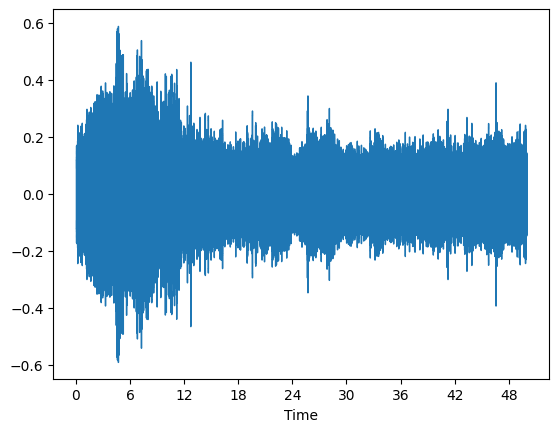

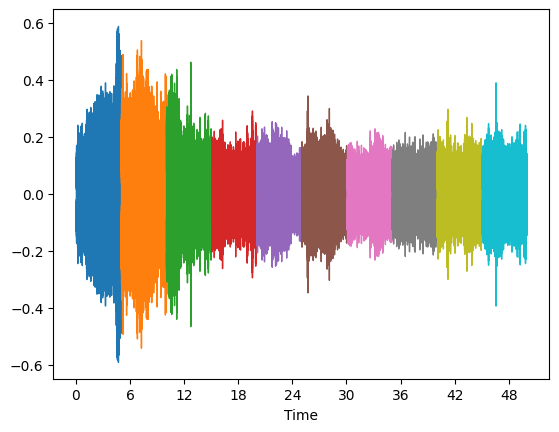

In [20]:
import math
import matplotlib.pyplot as plt
from scipy import signal

# Load a soundscape
# y, sr = librosa.load("datasets/birdclef_2021/train_soundscapes/18003_COR_20190904.ogg", sr=SAMPLE_RATE)
y, sr = librosa.load("datasets/birdclef_2021/train_soundscapes/21767_COR_20190904.ogg", sr=SAMPLE_RATE)

# Filter for the current file
CURRENT_SITE = "COR"
CURRENT_ID = 21767

# Pass it through a bandpass
b, a = signal.butter(4, [200, 7999], fs=SAMPLE_RATE, btype='band')
y = signal.lfilter(b, a, y)

# Cut it into chunks of BYTES_PER_SECOND
chunks = []
for i in range(0, math.ceil(len(y)/BYTES_PER_SECOND)):
    chunk = y[i*BYTES_PER_SECOND:(i+1)*BYTES_PER_SECOND]
    chunks.append(chunk)
    
count = 10
librosa.display.waveshow(y[:count*BYTES_PER_SECOND], sr=SAMPLE_RATE)
plt.show()

for i in range(count):
    librosa.display.waveshow(chunks[i], offset=i*SECONDS, sr=SAMPLE_RATE)
    
plt.show()
# Listen to the first sample
import IPython.display
IPython.display.Audio(chunks[0], rate=SAMPLE_RATE)

(128, 157)


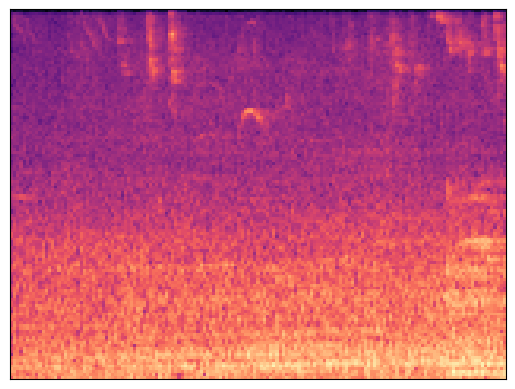

In [21]:
# Convert the chunks into spectrograms
for i, chunk in enumerate(chunks):
    chunks[i] = generate_mel_spectrogram(chunk)

print(chunks[i].shape)
    
plt.show()
librosa.display.specshow(chunks[0])

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
0.170 at 0.692


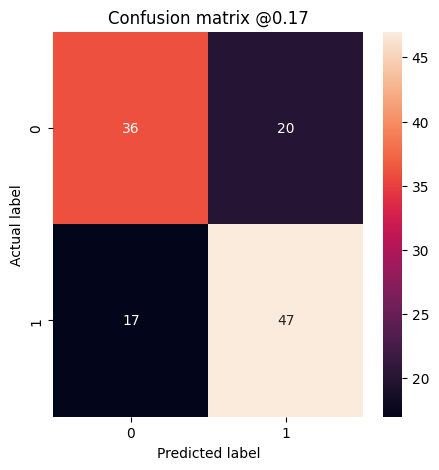

In [22]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Load the labels
soundscape_labels = pd.read_csv("datasets/birdclef_2021/train_soundscape_labels.csv")

soundscape_labels = soundscape_labels[(soundscape_labels["site"] == CURRENT_SITE) & (soundscape_labels["audio_id"] == CURRENT_ID)]

chunks = np.array(chunks)
# Predict the labels with the model
predictions = model.predict(chunks)

soundscape_labels["class"] = soundscape_labels["birds"].apply(lambda x: "target" if TARGET in x else "other")
soundscape_labels["predictions"] = predictions

soundscape_labels.to_csv("Soundscape_Predictions.csv")

def plot_cm(df: pd.DataFrame, threshold=0.1):
    labels = df["predictions"].apply(lambda x: "target" if x > threshold else "other")
    cm = confusion_matrix(df["class"], labels)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(threshold))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
  
max_thres = 0
max_val = -1
for t in np.arange(0.01, 1.0, 0.01):
    # Threshold tuning
    soundscape_labels["label"] = soundscape_labels["predictions"].apply(lambda x: "target" if x > t else "other")
    # Calculate accuracy
    correct = (soundscape_labels["label"] == soundscape_labels["class"]).mean()
    if (correct > max_val):
        max_val = correct
        max_thres = t
    
print(f"{max_thres:.3f} at {max_val:.3f}")
plot_cm(soundscape_labels, threshold=max_thres)